In [53]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text

from tensorflow.keras import models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Load dataset

I will use the [IMDb movie reviews sentiment analysis dataset](https://ai.stanford.edu/%7Eamaas/data/sentiment/) which contains **movie reviews** posted by people on the [IMDb website](https://www.imdb.com/), as well as the corresponding labels ("positive” or “negative”) indicating whether the reviewer liked the movie or not. There are 50,000 movie reviews divided into 25,000 reviews for training and 25,000 reviews for testing. The training and test sets are balanced, meaning they contain the same number of positive and negative reviews.

The data samples may be in a specific order. A simple best practice to ensure the model is not affected by data order is to always first shuffle the data.

In [54]:
def load_dataset(data_path, seed=123):

    """Loads the IMDb movie reviews sentiment analysis dataset.

    Arguments
    - data_path: string, path to the data directory.
    - seed: int, seed for randomizer.

    Returns
    - A tuple of training, validation, and testing data.

    References
    - Download and uncompress archive from:
    http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname), encoding='utf-8') as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)
    
    # Shuffle the training data and labels
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    # Load the test data
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname), encoding='utf-8') as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)
    
    # Split test data into test and validation data
    val_texts = test_texts[:10000]
    val_labels = test_labels[:10000]
    test_texts = test_texts[10000:]
    test_labels = test_labels[10000:]

    return ((train_texts, np.array(train_labels)),
            (val_texts, np.array(val_labels)),
            (test_texts, np.array(test_labels)))

## Explore dataset

In [55]:
(train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels) = load_dataset(r"C:\Users\danie\Desktop\Projects\sentiment-analysis")

In [56]:
print(f"Number of training samples: {len(train_texts)}")
print(f"Number of validation samples: {len(val_texts)}")
print(f"Number of test samples: {len(test_texts)}")

Number of training samples: 25000
Number of validation samples: 10000
Number of test samples: 15000


Let's see how our data looks like and check if the sentiment label corresponds to the sentiment of the review in a random sample:

In [57]:
train_texts[5]

'A pointless movie with nothing but gratuitous violence. The only fun I had was playing "spot the location", as much of it was filmed in my home town of Regina, Saskatchewan. I like to support locally produced films but this one was a major disappointment.'

The expected sentiment (negative) matches the sample’s label:

In [58]:
train_labels[5]

0

## Chose a model

[Google Developers](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) have created the following model selection algorithm and flowchart attempting to significantly simplify the process of selecting a text classification model. For a given dataset, their goal was to find the algorithm that achieves close to maximum accuracy while minimizing computation time required for training.

Models can be broadly classified into two categories:

- **N-gram models (Models that just see text as “bags” (sets) of words):** With n-gram vector representation, we discard a lot of information about word order and grammar. This representation is used in conjunction with models that don’t take ordering into account, such as logistic regression, simple multi-layer perceptrons (MLPs, or fully-connected neural networks), gradient boosted trees and support vector machines.

- **Sequence models (Models that use word ordering information):** For some text samples, word order is critical to the text’s meaning. Models such as convolutional neural networks (CNNs), and recurrent neural networks (RNNs) can infer meaning from the order of words in a sample.


The ratio of *number of samples* to *number of words per sample* correlates with which model performs better. 
- When the value for this ratio is **small (<1500)**, small multi-layer perceptrons that take **n-grams** as input perform better or at least as well as sequence models. MLPs are simple to define and understand, and they take much less compute time than sequence models. 
- When the value for this ratio is **large (>= 1500)**, a **sequence** model is a better option. Sequence models are better when there are a large number of small, dense vectors. This is because embedding relationships are learned in dense space, and this happens best over many samples.

<br>

**Model selection algorithm:**
1. Calculate the *number of samples* to *number of words per sample* ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
- Split the samples into word n-grams and convert the n-grams into vectors.
- Score the importance of the vectors and then select the top 20K using the scores.
- Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
- Split the samples into words and select the top 20K words based on their frequency.
- Convert the samples into word sequence vectors.
- If the ratio is less than 15K, using a fine-tuned pre-trained embedding with the sepCNN model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find the best model configuration for the dataset.

<br>

**Flowchart:**

In the flowchart below, the yellow boxes indicate data and model preparation processes. Grey boxes and green boxes indicate choices they considered for each process. Green boxes indicate their recommended choice for each process.

<div style="width: 700px; overflow: hidden;">
    <img src="https://developers.google.com/static/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png" width="100%" alt="Your Image">
</div>

Let's compute the *number of samples* to *number of words per sample* ratio:

In [59]:
def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.

    Arguments
    - sample_texts: list, sample texts.

    Returns
    - int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [60]:
25000 / get_num_words_per_sample(train_texts)

143.67816091954023

In the case of our IMDb review dataset, the ratio of *number of samples* to *number of words per sample* is less than 1500 so we should choose a n-gram model. We will create a n-gran model and sequence model for practice and comparison.

## Data pre-procesing

Machine learning algorithms take numbers as inputs. This means that we will need to convert the texts into numerical vectors. There are two steps to this process:

- **1. Tokenization:** Divide the texts into words or smaller sub-texts, which will enable good generalization of relationship between the texts and the labels. This determines the “vocabulary” of the dataset (set of unique tokens present in the data).
- **2. Vectorization:** Define a good numerical measure to characterize these texts.

Let’s see how to perform these two steps for both **n-gram vectors** and **sequence vectors**, as well as how to optimize the vector representations using feature selection and normalization techniques.

### N-gram vectors

In an n-gram vector, text is represented as a **collection of unique n-grams: groups of n adjacent tokens** (typically, words).

<br>

**1. Tokenization**

First, we have to split (tokenize) the text samles into word unigrams and bigrams. Thus, we will determines the "vocabulary" of the dataset. In the case of the text sample *'The mouse ran up the clock'*.

- The word unigrams (n = 1) are ['the', 'mouse', 'ran', 'up', 'clock']

- The word bigrams (n = 2) are ['the mouse', 'mouse ran', 'ran up', 'up the', 'the clock']

<br>

**2. Vectorization**

Once we have split our text samples into n-grams, we need to turn these n-grams into numerical vectors that our machine learning models can process. In the case of the text samples *'The mouse ran up the clock'* and *'The mouse ran down'*.

- The indexes assigned to the unigrams and bigrams would be {'clock': 0, 'down': 1, 'mouse': 2, 'mouse ran': 3, 'ran': 4, 'ran down': 5, 'ran up': 6, 'the': 7, 'the clock': 8, 'the mouse': 9, 'up': 10, 'up the': 11}


Once indexes are assigned to the n-grams, we typically vectorize the text samples using one-hot encoding, count encoding, or **Tf-idf encoding**. This last option is recommend for vectorizing n-grams. In the case of the  text sample *'The mouse ran up the clock'*.
- The vectorization using Tf-idf encoding would be [0.33, 0, 0.23, 0.23, 0.23, 0, 0.33, 0.47, 0.33, 0.23, 0.33, 0.33]

<br>

**3. Feature selection**

When we convert all of the texts in a dataset into word uni+bigram tokens, we may end up with tens of thousands of tokens. Not all of these tokens/features contribute to label prediction so we can drop certain tokens, for instance those that occur extremely rarely across the dataset. We can also measure feature importance (how much each token contributes to label predictions), and only include the most informative tokens. Two commonly used functions to calculate feature importance are **f_classif** and chi2. In addition, it has been noticed that accuracy peaks at around 20,000 features for many datasets.

<br>

The following code:
- Tokenize text samples into word unigrams + bigrams.
- Vectorize using tf-idf encoding.
- Select only the top 20,000 features from the vector of tokens by discarding tokens that appear fewer than 2 times and using f_classif to calculate feature importance.

Vectorization parameters:

In [61]:
# Range (inclusive) of n-gram sizes for tokenizing text
NGRAM_RANGE = (1, 2)

# Whether text should be split into word or character n-grams ('word' or 'char')
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the number of features. We use the top 20K features
TOP_K = 20000

In [62]:
def ngram_vectorize(train_texts, train_labels, val_texts, test_texts):
    """Vectorizes texts as n-gram vectors
    
    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams

    Arguments:
    - train_texts: list, training text strings
    - train_labels: np.ndarray, training labels
    - val_texts: list, validation text strings
    - test_texts: list, test text strings

    Returns:
    - train_texts, val_texts, test_texts: vectorized training, validation, and test texts
    """

    # Create keyword arguments to pass to the 'tf-idf' vectorizer
    kwargs = {
        'ngram_range': NGRAM_RANGE,
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts
    train_texts = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts
    val_texts = vectorizer.transform(val_texts)

    # Vectorize test texts
    test_texts = vectorizer.transform(test_texts)
    
    # Select top 'k' of the vectorized features
    selector = SelectKBest(f_classif, k=min(TOP_K, train_texts.shape[1]))
    selector.fit(train_texts, train_labels)
    train_texts = selector.transform(train_texts).astype('float32')
    val_texts = selector.transform(val_texts).astype('float32')
    test_texts = selector.transform(test_texts).astype('float32')
    return train_texts, val_texts, test_texts

### Sequence vectors

In a sequence vector, text is represented as a **sequence of tokens, preserving order**.

<br>

**1. Tokenization**

Text can be represented as either a sequence of characters, or a sequence of words. Using word-level representation provides better performance than character tokens. Using character tokens makes sense only if texts have lots of typos.

<br>

**2. Vectorization**

Once we have converted our text samples into sequences of words, we need to turn these sequences into numerical vectors. The example below shows the indexes assigned to the unigrams generated for two texts, and then the sequence of token indexes to which the first text is converted.

- Texts: 'The mouse ran up the clock' and 'The mouse ran down'
- Index assigned for every token: {'the': 1, 'mouse': 2, 'ran': 3, 'up': 4,'clock': 5, 'down': 6}.
- Sequence of token indexes: 'The mouse ran up the clock' = [1, 2, 3, 4, 1, 5]

Note that 'the' occurs most frequently, so the index value of 1 is assigned to it. Also some libraries reserve index 0 for unknown tokens, as is the case here.

To vectorize the token sequences we can use one-hot encoding, or **word embeddings**. This last option is recommend for vectorizing sequences since words have meaning(s) associated with them. As a result, we can represent word tokens in a dense vector space (~few hundred real numbers), where the location and distance between words indicates how similar they are semantically.


<div style="width: 900px; overflow: hidden;">
    <img src="https://developers.google.com/static/machine-learning/guides/text-classification/images/WordEmbeddings.png" width="100%" alt="Your Image">
</div>

Sequence models often have such an embedding layer as their first layer. This layer learns to **turn word index sequences into word embedding vectors** during the training process, such that **each word index gets mapped to a dense vector** of real values representing that word’s location in semantic space.

<div style="width: 900px; overflow: hidden;">
    <img src="https://developers.google.com/static/machine-learning/guides/text-classification/images/EmbeddingLayer.png" width="100%" alt="Your Image">
</div>

<br>

**3. Feature selection**

As in n-gram models, not all words in our data contribute to label predictions. We can optimize our learning process by discarding rare or irrelevant words from our vocabulary. Again, using the most frequent 20,000 features is generally sufficient.

<br>

The following code:

- Tokenizes the texts into words.
- Creates a vocabulary using the top 20,000 tokens.
- Converts the tokens into sequence vectors.
- Pads the sequences to a fixed sequence length.

Vectorization parameters:

In [63]:
# Limit on the number of features. We use the top 20K features
TOP_K = 20000

# Limit on the length of text sequences (sequences longer than this will be truncated)
MAX_SEQUENCE_LENGTH = 500

In [64]:
def sequence_vectorize(train_texts, val_texts, test_texts):
    """Vectorizes texts as sequence vectors

    1 text = 1 sequence vector with fixed length

    Arguments
    - train_texts: list, training text strings
    - val_texts: list, validation text strings
    - test_texts: list, test text strings

    Returns:
    - train_texts, val_texts, test_texts, word_index: vectorized training, validation, and test texts; and word index dictionary.
    """

    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    train_texts = tokenizer.texts_to_sequences(train_texts)
    val_texts = tokenizer.texts_to_sequences(val_texts)
    test_texts = tokenizer.texts_to_sequences(test_texts)

    # Get max sequence length.
    max_length = len(max(train_texts, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated at the beginning.
    train_texts = sequence.pad_sequences(train_texts, maxlen=max_length)
    val_texts = sequence.pad_sequences(val_texts, maxlen=max_length)
    test_texts = sequence.pad_sequences(test_texts, maxlen=max_length)
    
    return train_texts, val_texts, test_texts, tokenizer.word_index

## Build Models

### Output layer

When there are **only 2 classes (binary classification)**, the model should **output a single probability score**. For instance, outputting 0.14 for a given input sample means “14% confidence that this sample is in class 1, 86% that it is in class 2.” To output such a probability score, the activation function of the last layer should be a sigmoid function, and the loss function used to train the model should be binary cross-entropy.

When there are **more than 2 classes (multi-class classification)**, the model should **output one probability score per class**. The sum of these scores should be 1. For instance, outputting {0: 0.01, 1: 0.14, 2: 0.85} means “1% confidence that this sample is in class 1, 14% that it is in class 2, and 85% that it is in class 3.” To output these scores, the activation function of the last layer should be softmax, and the loss function used to train the model should be categorical cross-entropy.


<div style="width: 900px; overflow: hidden;">
    <img src="https://developers.google.com/static/machine-learning/guides/text-classification/images/LastLayer.png" width="100%" alt="Your Image">
</div>

The following code defines a function that takes the number of classes as input, and outputs the appropriate output layer **# of units** (1 unit for binary classification; otherwise 1 unit for each class) and **activation function**:

In [65]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    Arguments
    - num_classes: int, number of classes.

    Returns
    - units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

### N-gram model

**Multi-layer perceptrons (MLPs)** typically perform better since they are simple to define and understand, provide good accuracy, and require relatively little computation. The following code defines a MLP model using tensorflow.keras, adding Dropout layers for regularization (to prevent overfitting to training samples):

In [66]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    Arguments
    - layers: int, number of `Dense` layers in the model.
    - units: int, output dimension of the `Dense` layers.
    - dropout_rate: float, percentage of input to drop at `Dropout` layers.
    - input_shape: tuple, shape of input to the model.
    - num_classes: int, number of output classes.

    Returns
    - An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    model.add(Input(input_shape))
    model.add(Dropout(rate=dropout_rate))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

### Sequence model

As mentioned before, sequence models that can **learn from the adjacency of tokens**. They generally have a larger number of parameters to learn. The first layer in these models is an **embedding layer**, which learns the relationship between the words in a dense vector space. Learning word relationships works best over many samples.

Words in a given dataset are most likely not unique to that dataset. We can thus learn the relationship between the words in our dataset using other datasets. To do so, we can transfer an embedding learned from another dataset into our embedding layer. These embeddings are referred to as **pre-trained embeddings**. Using a pre-trained embedding gives the model a head start in the learning process.

There are pre-trained embeddings available that have been trained using large corpora, such as [GloVe](https://nlp.stanford.edu/projects/glove/). GloVe embeddings trained on Wikipedia data may not align with the language patterns in our IMDb dataset. The relationships inferred may need some updating (the embedding weights may need contextual tuning). We can do this in two stages:

- In the first run, with the embedding layer weights frozen, we allow the rest of the network to learn. At the end of this run, the model weights reach a state that is much better than their uninitialized values. For the second run, we allow the embedding layer to also learn, making fine adjustments to all weights in the network. We refer to this process as using a **fine-tuned embedding**.

- Fine-tuned embeddings yield better accuracy. However, this comes at the expense of increased compute power required to train the network. Given a sufficient number of samples (the ratio of *number of samples* to *number of words per sample* > 15k), we could do just as well **learning an embedding from scratch**.

**sepCNNs**, a convolutional network variant, is often more efficient and perform better than other models.

In [67]:
def sepcnn_model(blocks, filters, kernel_size, embedding_dim, dropout_rate, pool_size,
                 input_shape, num_classes, num_features, use_pretrained_embedding=False,
                 is_embedding_trainable=False, embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    Arguments
    - blocks: int, number of pairs of sepCNN and pooling blocks in the model.
    - filters: int, output dimension of the layers.
    - kernel_size: int, length of the convolution window.
    - embedding_dim: int, dimension of the embedding vectors.
    - dropout_rate: float, percentage of input to drop at Dropout layers.
    - pool_size: int, factor by which to downscale input at MaxPooling layer.
    - input_shape: tuple, shape of input to the model.
    - num_classes: int, number of output classes.
    - num_features: int, number of words (embedding input dimension).
    - use_pretrained_embedding: bool, true if pre-trained embedding is on.
    - is_embedding_trainable: bool, true if embedding layer is trainable.
    - embedding_matrix: dict, dictionary with embedding coefficients.

    Returns
    - A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

## Train models

Training involves making a prediction based on the current state of the model, calculating how incorrect the prediction is, and updating the weights and biases of the network to minimize this error and make the model predict better. We repeat this process until our model has converged and can no longer learn. There are three key parameters to be chosen for this process:
- **Optimizer:** A function that decides how the network weights will be updated based on the output of the loss function.
- **Loss function:** A function that is used to calculate a loss value that the training process then attempts to minimize by tuning the network weights.
- **Metric:** How to measure the performance of our model using a metric. We used accuracy as the metric in our experiments.

In each training iteration, **batch_size** number of samples from your training data are used to compute the loss, and the weights are updated once, based on this value. The training process completes an **epoch** once the model has seen the entire training dataset. At the end of each epoch, we use the validation dataset to evaluate how well the model is learning. We repeat training using the dataset for a predetermined number of epochs. We may optimize this by **stopping early**, when the validation accuracy stabilizes between consecutive epochs, showing that the model is not learning anymore.

### N-gram model

In [68]:
def train_ngram_model(train_texts, train_labels, val_texts, val_labels, test_texts, layers=2, units=64, dropout_rate=0.2, num_classes=2, learning_rate=1e-4, epochs=1000, batch_size=128):
    """Trains n-gram model on the given dataset.

    Arguments
    - data: tuples of training and test texts and labels.
    - layers: int, number of `Dense` layers in the model.
    - units: int, output dimension of the `Dense` layers.
    - dropout_rate: float, percentage of input to drop at `Dropout` layers.
    - input_shape: tuple, shape of input to the model.
    - num_classes: int, number of output classes.
    - learning_rate: float, learning rate for training model.
    - epochs: int, number of epochs.
    - batch_size: int, number of samples per batch.
    """

    # Vectorize texts
    train_texts, val_texts, test_texts = ngram_vectorize(train_texts, train_labels, val_texts, test_texts)

    # Converse sparse matrix to a dense np.array
    train_texts = train_texts.toarray()

    # Create model instance
    model = mlp_model(layers=layers, 
                      units=units, 
                      dropout_rate=dropout_rate,
                      input_shape=train_texts.shape[1:],
                      num_classes=num_classes)

    # Compile model with learning parameters
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss.
    # If the loss does not decrease in patience consecutive tries, stop training.
    callbacks = [EarlyStopping(monitor='val_loss', patience=4)]

    # Train and validate model.
    history = model.fit(
            train_texts,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(val_texts, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    print(f"\nValidation accuracy: {history.history['val_acc'][-1]}, loss: {history.history['val_loss'][-1]}")

    # Save model.
    model.save('ngram_model.keras')

    return model, history, test_texts

In [69]:
ngram_model, ngram_history, ngram_test_texts = train_ngram_model(train_texts, train_labels, val_texts, val_labels, test_texts)

Epoch 1/1000
196/196 - 9s - 47ms/step - acc: 0.7952 - loss: 0.6724 - val_acc: 0.8652 - val_loss: 0.6496
Epoch 2/1000
196/196 - 6s - 32ms/step - acc: 0.8793 - loss: 0.6136 - val_acc: 0.8557 - val_loss: 0.6017
Epoch 3/1000
196/196 - 6s - 32ms/step - acc: 0.8851 - loss: 0.5516 - val_acc: 0.8644 - val_loss: 0.5476
Epoch 4/1000
196/196 - 6s - 31ms/step - acc: 0.8899 - loss: 0.4930 - val_acc: 0.8747 - val_loss: 0.4938
Epoch 5/1000
196/196 - 6s - 30ms/step - acc: 0.8958 - loss: 0.4410 - val_acc: 0.8810 - val_loss: 0.4488
Epoch 6/1000
196/196 - 6s - 31ms/step - acc: 0.9004 - loss: 0.3970 - val_acc: 0.8860 - val_loss: 0.4124
Epoch 7/1000
196/196 - 6s - 32ms/step - acc: 0.9056 - loss: 0.3616 - val_acc: 0.8863 - val_loss: 0.3876
Epoch 8/1000
196/196 - 6s - 31ms/step - acc: 0.9080 - loss: 0.3326 - val_acc: 0.8842 - val_loss: 0.3697
Epoch 9/1000
196/196 - 6s - 31ms/step - acc: 0.9122 - loss: 0.3089 - val_acc: 0.8925 - val_loss: 0.3427
Epoch 10/1000
196/196 - 6s - 31ms/step - acc: 0.9163 - loss: 0.2

In [70]:
ngram_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

### Sequence model

In [71]:

def train_sequence_model(train_texts, train_labels, val_texts, val_labels, test_texts, blocks=2, filters=64, kernel_size=3, embedding_dim=200, 
                         dropout_rate=0.2, pool_size=3, num_classes=2, learning_rate=1e-4, epochs=1000, batch_size=128):
    """Trains sequence model on the given dataset.

    Arguments
    - data: tuples of training and test texts and labels.
    - learning_rate: float, learning rate for training model.
    - epochs: int, number of epochs.
    - batch_size: int, number of samples per batch.
    - blocks: int, number of pairs of sepCNN and pooling blocks in the model.
    - filters: int, output dimension of sepCNN layers in the model.
    - dropout_rate: float: percentage of input to drop at Dropout layers.
    - embedding_dim: int, dimension of the embedding vectors.
    - kernel_size: int, length of the convolution window.
    - pool_size: int, factor by which to downscale input at MaxPooling layer.
    """

    # Vectorize texts
    train_texts, val_texts, test_texts, word_index = sequence_vectorize(train_texts, val_texts, test_texts)

    # Number of features will be the embedding input dimension. Add 1 for the reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance
    model = sepcnn_model(blocks=blocks, 
                         filters=filters,
                         kernel_size=kernel_size,
                         embedding_dim=embedding_dim,
                         dropout_rate=dropout_rate,
                         pool_size=pool_size,
                         input_shape=train_texts.shape[1:],
                         num_classes=num_classes,
                         num_features=num_features)

    # Compile model with learning parameters
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    
    model.compile(optimizer=Adam(lr=learning_rate), loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in patience consecutive tries, stop training.
    callbacks = [EarlyStopping(monitor='val_loss', patience=4)]

    # Train and validate model.
    history = model.fit(
            train_texts,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(val_texts, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)
    
    # Print results.
    print(f"\nValidation accuracy: {history.history['val_acc'][-1]}, loss: {history.history['val_loss'][-1]}")

    # Save model.
    model.save('sequence_model.keras')

    return model, history, test_texts

In [72]:
sequence_model, sequence_history, sequence_test_texts= train_ngram_model(train_texts, train_labels, val_texts, val_labels, test_texts)

Epoch 1/1000
196/196 - 10s - 51ms/step - acc: 0.7756 - loss: 0.6718 - val_acc: 0.8051 - val_loss: 0.6597
Epoch 2/1000
196/196 - 7s - 38ms/step - acc: 0.8744 - loss: 0.6110 - val_acc: 0.8396 - val_loss: 0.6069
Epoch 3/1000
196/196 - 7s - 36ms/step - acc: 0.8835 - loss: 0.5479 - val_acc: 0.8523 - val_loss: 0.5548
Epoch 4/1000
196/196 - 7s - 34ms/step - acc: 0.8892 - loss: 0.4895 - val_acc: 0.8658 - val_loss: 0.5008
Epoch 5/1000
196/196 - 7s - 33ms/step - acc: 0.8957 - loss: 0.4382 - val_acc: 0.8657 - val_loss: 0.4648
Epoch 6/1000
196/196 - 7s - 33ms/step - acc: 0.9010 - loss: 0.3956 - val_acc: 0.8670 - val_loss: 0.4352
Epoch 7/1000
196/196 - 6s - 33ms/step - acc: 0.9050 - loss: 0.3602 - val_acc: 0.8716 - val_loss: 0.4065
Epoch 8/1000
196/196 - 7s - 34ms/step - acc: 0.9089 - loss: 0.3310 - val_acc: 0.8806 - val_loss: 0.3762
Epoch 9/1000
196/196 - 7s - 34ms/step - acc: 0.9126 - loss: 0.3081 - val_acc: 0.8841 - val_loss: 0.3555
Epoch 10/1000
196/196 - 7s - 33ms/step - acc: 0.9154 - loss: 0.

In [73]:
sequence_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

## Tune hyperparameters

In [74]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'], label = 'Val Accuracy')
    plt.legend()
    plt.show()

### N-gram model

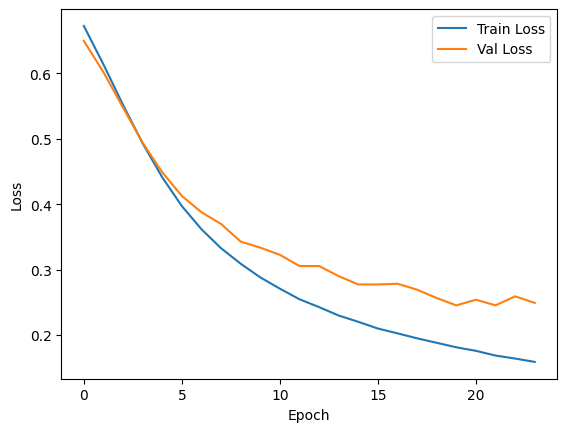

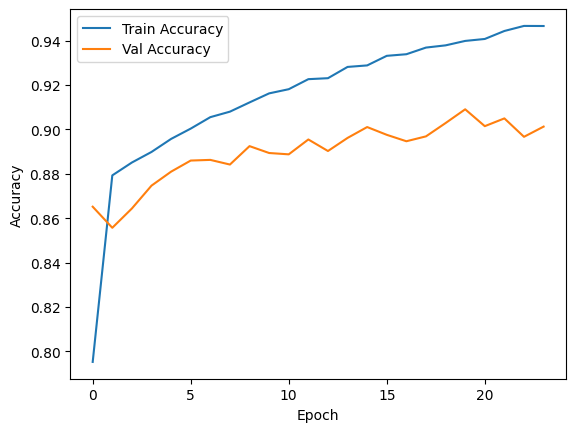

In [75]:
plot_history(ngram_history)

### Sequence model

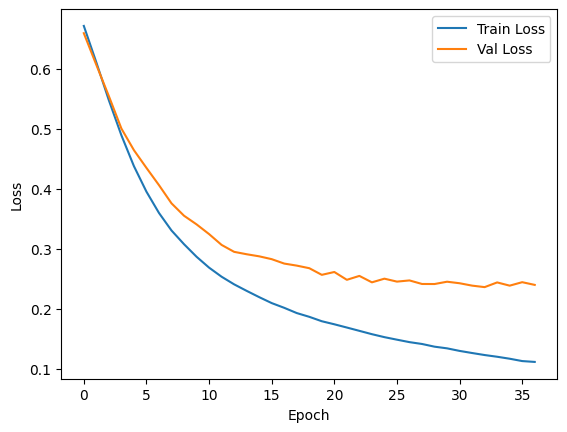

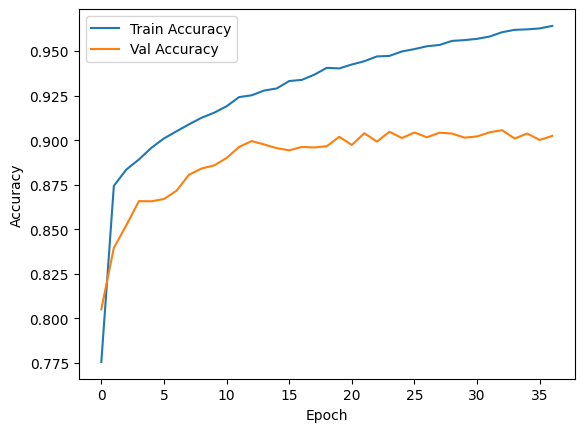

In [76]:
plot_history(sequence_history)

## Evaluate model

### N-gram model

In [77]:
loss, acc = ngram_model.evaluate(ngram_test_texts, test_labels)
print(f"N-gram model loss: {loss:.2f}")
print(f"N-gram model accuracy: {acc * 100:.2f}%")

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9123 - loss: 0.2249
N-gram model loss: 0.23
N-gram model accuracy: 90.72%


### Sequence model

In [78]:
loss, acc = sequence_model.evaluate(sequence_test_texts, test_labels)
print(f"Sequence model loss: {loss:.2f}")
print(f"Sequence model accuracy: {acc * 100:.2f}%")

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.9141 - loss: 0.2113
Sequence model loss: 0.22
Sequence model accuracy: 90.93%
